# Praktikum 1
RNN untuk Analisis Sentimen

**Setup**

Impor matplotlib dan buat fungsi pembantu untuk memplot grafik:

In [ ]:
# Import libraries
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf

# Disable progress bar
tfds.disable_progress_bar()

In [ ]:
# Mengimpor library yang diperlukan
import matplotlib.pyplot as plt

# Membuat fungsi untuk menggambar grafik
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])


**Setup input pipeline**
Dataset ulasan film IMDB adalah kumpulan data klasifikasi biner—semua ulasan memiliki sentimen positif atau negatif.

Download dataset menggunakan [TFDS](https://www.tensorflow.org/datasets).Lihat [loading next tutorial](https://www.tensorflow.org/datasets) jika ingin me load data secara manual.

In [ ]:
# Memuat dataset 'imdb_reviews' dari TensorFlow Datasets
# dengan informasi tambahan (with_info=True) dan mengambil dataset sebagai dataset terawasi (as_supervised=True)
dataset, info = tfds.load('imdb_reviews', with_info=True, as_supervised=True)

# Membagi dataset menjadi dua bagian: data latihan dan data uji
train_dataset, test_dataset = dataset['train'], dataset['test']

# Menampilkan spesifikasi elemen dataset latihan
train_dataset.element_spec


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

Awalnya ini mengembalikan dataset (teks, pasangan label):

In [ ]:
# Mengambil satu contoh dari dataset latihan (train_dataset)
for example, label in train_dataset.take(1):
    print('text: ', example.numpy())  # Mencetak teks ulasan
    print('label: ', label.numpy())  # Mencetak label


text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


Berikutnya acak data untuk pelatihan dan membuat kumpulan pasangan (teks, label) ini:

In [ ]:
# Mengatur ukuran buffer untuk percampuran data
BUFFER_SIZE = 10000

# Mengatur ukuran batch data
BATCH_SIZE = 64

# Mengacak dataset latihan, membaginya menjadi batch, dan mengambil data secara otomatis
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Memasukkan dataset uji menjadi batch dan mengambil data secara otomatis
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Mengambil satu batch data dari dataset latihan
for example, label in train_dataset.take(1):
    print('texts: ', example.numpy()[:3])  # Mencetak teks ulasan dari tiga contoh pertama dalam batch
    print()
    print('labels: ', label.numpy()[:3])  # Mencetak label dari tiga contoh pertama dalam batch


texts:  [b"It's a strange thing to see a film where some scenes work rather weakly (if only in comparison to other films in its legacy), and others in a 'sub-plot' or supporting story are surprisingly provocative and strong. Sudden Impact is one of those cases, where Clint Eastwood as star/producer/director shows when he can be at his best, or at his lessor of times when dealing with a crime/mystery/detective story in his Dirty Harry fame. We get that 'make my day' line, and un-like in the first film where his 'do I feel lucky' speech was playful and cool the first time and the second time at the end tough as nails, here it's switched around. He gets into another shamble with the department, as usual, when he tries to fight crime 'his' way, in particular with a diner robbery (inspiration for Pulp Fiction?) and with a high speed pursuit with a senior citizen bus. He's told to 'take a vacation', and that's the last thing on his mind. This whole main plot isn't very convincing aside from 

**Buat Teks Encoder**

Teks mentah yang dimuat oleh tfds perlu diproses sebelum dapat digunakan dalam model. Cara termudah memproses teks untuk pelatihan adalah menggunakan lapisan TextVectorization. Lapisan ini memiliki banyak kemampuan, namun pada tutorial ini menggunakan perilaku default. Buat lapisan tersebut, dan teruskan teks kumpulan data ke metode .adapt lapisan:

In [ ]:
# Menentukan ukuran kosakata (VOCAB_SIZE) yang akan digunakan
VOCAB_SIZE = 1000

# Membuat lapisan TextVectorization dengan maksimum token (kata) sebanyak VOCAB_SIZE
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)

# Mengadaptasi lapisan encoder menggunakan dataset latihan
encoder.adapt(train_dataset.map(lambda text, label: text))


Metode .adapt mengatur kosakata lapisan. 20 token pertama dapat dilihat dengan kode berikut. Setelah padding dan token yang tidak diketahui, mereka diurutkan berdasarkan frekuensi:

In [ ]:
# Mengambil kosakata (vocabulary) dari lapisan encoder
vocab = np.array(encoder.get_vocabulary())

# Mencetak 20 kata pertama dalam kosakata
vocab[:20]


array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

Setelah kosakata diatur, lapisan dapat mengkodekan teks ke dalam indeks. Tensor indeks diberi bantalan 0 ke urutan terpanjang dalam batch (kecuali jika Anda menetapkan output_sequence_length tetap):

In [ ]:
# Mengambil tiga contoh pertama dari dataset latihan
example, _ = next(iter(train_dataset))
# Menerapkan lapisan encoder untuk mengkodekan teks menjadi vektor angka
encoded_example = encoder(example)[:3].numpy()
# Mencetak hasilnya
encoded_example


array([[ 47, 132,  26, ...,   0,   0,   0],
       [  9,  14,   4, ...,   0,   0,   0],
       [  1,   1,   1, ...,   0,   0,   0]])

Dengan pengaturan default, prosesnya tidak dapat dibalik sepenuhnya. Ada dua alasan utama untuk itu:

- Nilai default untuk argumen standarisasi preprocessing.TextVectorization adalah "lower_and_strip_punctuation".

- Ukuran kosa kata yang terbatas dan kurangnya fallback berbasis karakter menghasilkan beberapa token yang tidak diketahui.

In [ ]:
# Loop untuk tiga contoh pertama
for n in range(3):
    # Mencetak teks dalam format asli
    print("Original: ", example[n].numpy())

    # Mengonversi vektor angka (encoded_example) kembali ke teks menggunakan kosakata (vocab)
    # dan menggabungkannya menjadi satu kalimat
    print("Round-trip: ", " ".join(vocab[encoded_example[n]]))

    # Mencetak baris kosong
    print()


Original:  b"Some here have commented that this is the WORST Elvis movie ever made. Well, they are only partly right. For me, this IS THE WORST MOVIE EVER MADE PERIOD! I have never seen anything so basely crude, and insulting, and vile, and against human nature as this film. A true embarrassment to the Motion Picture Industry, this isn't even so Bad, its good. There is no campy trashy fun to be had here like in some of Elvis' other bad movies like Clambake. This one is so rotten to sit through its painful. Pure Garbage. Native Americans should sue for their poor clich\xc3\xa9d and stereotypical treatment here. Actually, perhaps ALL Human Beings should sue for the crime and disservice this movie does to the species as a whole 0 Stars, seriously. Grade: F"
Round-trip:  some here have [UNK] that this is the worst [UNK] movie ever made well they are only [UNK] right for me this is the worst movie ever made period i have never seen anything so [UNK] [UNK] and [UNK] and [UNK] and against hum

**Buat Model**
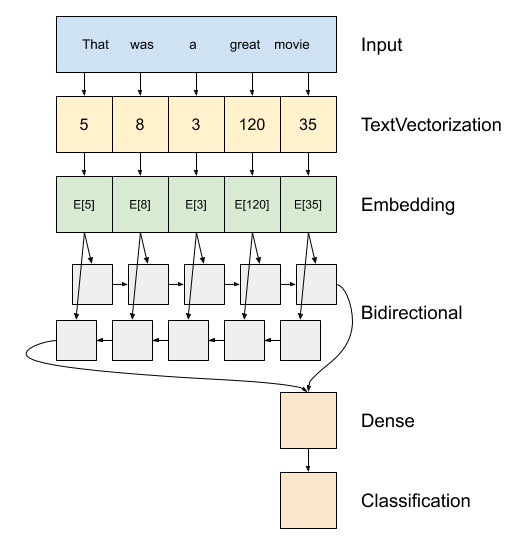


diagram model dapat dilihat pada gambar diatas

1. Model ini dapat dibuat sebagai tf.keras.Sequential.
2. Lapisan pertama adalah encoder, yang mengubah teks menjadi urutan indeks token.
3. Setelah encoder adalah lapisan penyematan (embedding layer). Lapisan penyematan menyimpan satu vektor per kata. Saat dipanggil, ini mengubah rangkaian indeks kata menjadi rangkaian vektor. Vektor-vektor ini dapat dilatih. Setelah pelatihan (dengan data yang cukup), kata-kata dengan arti yang mirip sering kali memiliki vektor yang serupa. Pencarian indeks ini jauh lebih efisien daripada operasi setara dengan meneruskan vektor yang disandikan one-hot melalui lapisan tf.keras.layers.Dense.
4. Jaringan saraf berulang (RNN) memproses masukan urutan dengan melakukan iterasi melalui elemen. RNN meneruskan keluaran dari satu langkah waktu ke masukannya pada langkah waktu berikutnya.
Pembungkus tf.keras.layers.Bidirection juga dapat digunakan dengan lapisan RNN. Ini menyebarkan masukan maju dan mundur melalui lapisan RNN dan kemudian menggabungkan keluaran akhir.
  - Keuntungan utama RNN dua arah adalah sinyal dari awal masukan tidak perlu diproses sepanjang waktu untuk memengaruhi keluaran.
  - Kerugian utama dari RNN dua arah adalah Anda tidak dapat melakukan streaming prediksi secara efisien saat kata-kata ditambahkan di akhir.
5. Setelah RNN mengonversi urutan menjadi satu vektor, kedua lapisan tersebut.Dense melakukan beberapa pemrosesan akhir, dan mengonversi representasi vektor ini menjadi logit tunggal sebagai keluaran klasifikasi.

Kode nya adalah sebagai berikut :

In [ ]:
# Membuat model Sequential
model = tf.keras.Sequential([
    # Lapisan encoder yang sudah dijelaskan sebelumnya
    encoder,

    # Lapisan embedding untuk mengubah vektor angka menjadi vektor embedding
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),  # Jumlah token dalam kosakata
        output_dim=64,  # Dimensi vektor embedding
        mask_zero=True  # Menggunakan masking untuk menangani panjang urutan yang berbeda
    ),

    # Lapisan LSTM yang bidirectional
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),

    # Lapisan Dense dengan aktivasi ReLU
    tf.keras.layers.Dense(64, activation='relu'),

    # Lapisan Dense dengan satu keluaran
    tf.keras.layers.Dense(1)
])


Harap dicatat bahwa model sekuensial Keras digunakan di sini karena semua lapisan dalam model hanya memiliki masukan tunggal dan menghasilkan keluaran tunggal. Jika Anda ingin menggunakan lapisan RNN stateful, Anda mungkin ingin membangun model Anda dengan API fungsional Keras atau subkelas model sehingga Anda dapat mengambil dan menggunakan kembali status lapisan RNN. Untuk detailnya bisa dilihat pada [Keras RNN Guide](https://www.tensorflow.org/guide/keras/working_with_rnns#rnn_state_reuse)

Lapisan penyematan menggunakan masking [(uses masking)](https://www.tensorflow.org/guide/keras/understanding_masking_and_padding)

In [ ]:
# Mencetak apakah setiap lapisan dalam model mendukung masking
print([layer.supports_masking for layer in model.layers])


[False, True, True, True, True]


Untuk memastikan bahwa ini berfungsi seperti yang diharapkan, evaluasi sebuah kalimat dua kali. Pertama, satu kalimat sehingga tidak ada bantalan (padding) untuk disamarkan:

In [ ]:
# predict on a sample text without padding.
# Contoh teks yang akan diprediksi
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')

# Melakukan prediksi menggunakan model pada contoh teks
predictions = model.predict(np.array([sample_text]))

# Mencetak hasil prediksi
print(predictions[0])


1/1 [==============================] - 3s 3s/step
[0.00421202]


Sekarang, evaluasi lagi dalam batch dengan kalimat yang lebih panjang. Hasilnya harus sama:

In [ ]:
# predict on a sample text with padding

# Contoh teks yang akan diprediksi tanpa padding
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')

# Teks untuk padding (panjang teks yang sangat besar)
padding = "the " * 2000

# Melakukan prediksi menggunakan model pada dua contoh teks: satu tanpa padding dan satu dengan padding
predictions = model.predict(np.array([sample_text, padding]))

# Mencetak hasil prediksi untuk contoh teks tanpa padding
print(predictions[0])


1/1 [==============================] - 0s 224ms/step
[0.00421202]


compile model Keras untuk mengonfigurasi proses pelatihan:

In [ ]:
# Mengkompilasi model dengan konfigurasi loss, optimizer, dan metrik
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),  # Menggunakan BinaryCrossentropy loss
    optimizer=tf.keras.optimizers.Adam(1e-4),  # Menggunakan optimizer Adam dengan learning rate 1e-4
    metrics=['accuracy']  # Menyertakan metrik akurasi
)


**Train Model**

In [ ]:
# Melatih model dengan dataset latihan selama 10 epoch
# dan melakukan validasi pada dataset uji
history = model.fit(
    train_dataset,  # Dataset latihan
    epochs=10,  # Jumlah epoch pelatihan
    validation_data=test_dataset,  # Dataset uji
    validation_steps=30  # Jumlah langkah validasi
)


391/391 [==============================] - 348s 888ms/step - loss: 0.4546 - accuracy: 0.7766 - val_loss: 0.3889 - val_accuracy: 0.8177
Epoch 3/10
391/391 [==============================] - 343s 876ms/step - loss: 0.3548 - accuracy: 0.8411 - val_loss: 0.3480 - val_accuracy: 0.8411
Epoch 4/10
391/391 [==============================] - 346s 884ms/step - loss: 0.3266 - accuracy: 0.8560 - val_loss: 0.3301 - val_accuracy: 0.8531
Epoch 5/10
391/391 [==============================] - 345s 883ms/step - loss: 0.3134 - accuracy: 0.8646 - val_loss: 0.3311 - val_accuracy: 0.8573
Epoch 6/10
391/391 [==============================] - 344s 881ms/step - loss: 0.3048 - accuracy: 0.8698 - val_loss: 0.3272 - val_accuracy: 0.8557
Epoch 7/10
391/391 [==============================] - 343s 877ms/step - loss: 0.3027 - accuracy: 0.8698 - val_loss: 0.3188 - val_accuracy: 0.8573
Epoch 8/10
391/391 [==============================] - 343s 878ms/step - loss: 0.2989 - accuracy: 0.8729 - val_loss: 0.3185 - val_accura

In [ ]:
# Melakukan evaluasi model pada dataset uji
test_loss, test_acc = model.evaluate(test_dataset)

# Mencetak hasil evaluasi, yaitu nilai loss dan akurasi pada dataset uji
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 96s 245ms/step - loss: 0.3220 - accuracy: 0.8611
Test Loss: 0.3220219910144806
Test Accuracy: 0.8610799908638


(0.0, 0.3383341357111931)

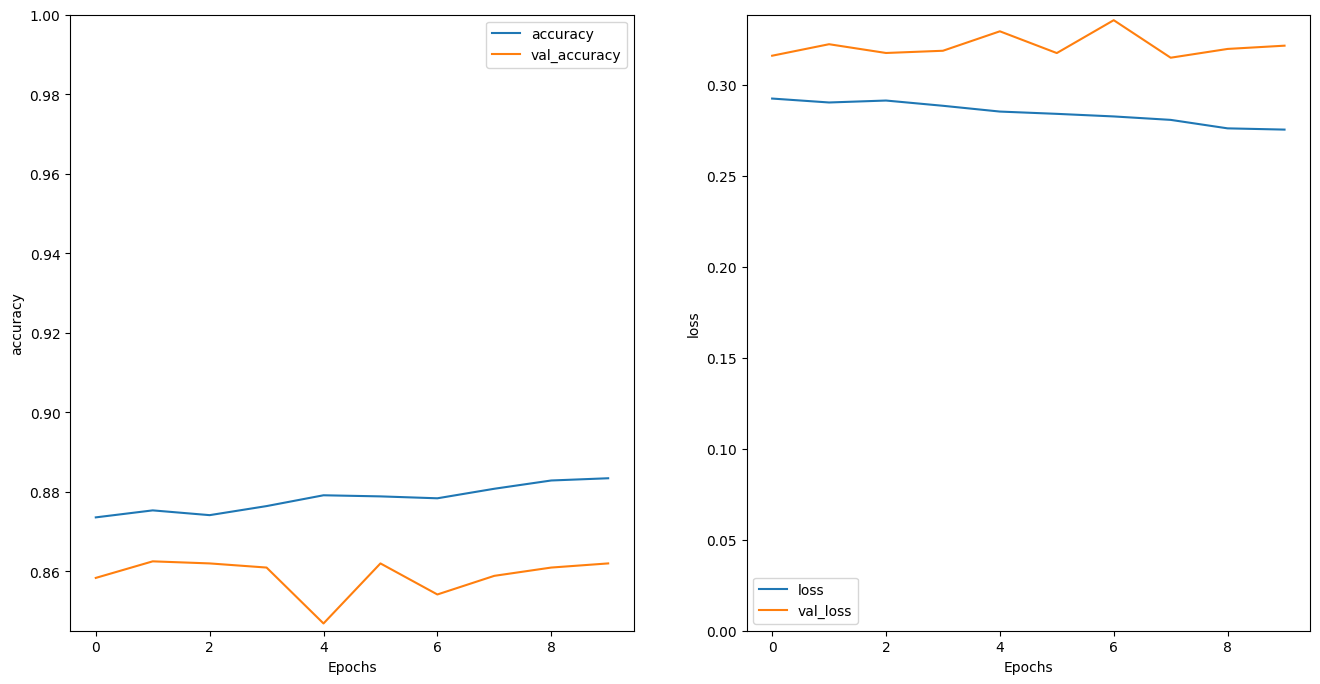

In [ ]:
# Membuat gambar dengan ukuran 16x8 piksel
plt.figure(figsize=(16, 8))

# Mengatur subplot pertama untuk grafik akurasi
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')  # Memanggil fungsi plot_graphs untuk grafik akurasi
plt.ylim(None, 1)  # Mengatur rentang akurasi pada sumbu y dari 0 hingga 1

# Mengatur subplot kedua untuk grafik loss
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')  # Memanggil fungsi plot_graphs untuk grafik loss
plt.ylim(0, None)  # Mengatur rentang loss pada sumbu y dari 0 hingga nilai maksimum


Jalankan prediksi pada kalimat baru:

Jika prediksi >= 0,0 berarti positif, jika tidak maka negatif.

In [ ]:
# Contoh teks yang akan diprediksi
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')

# Melakukan prediksi sentimen pada contoh teks menggunakan model yang telah dilatih
predictions = model.predict(np.array([sample_text]))


1/1 [==============================] - 2s 2s/step


# Stack two or more LSTM layers


Lapisan berulang Keras memiliki dua mode yang tersedia yang dikontrol oleh argumen konstruktor return_sequences :

- Jika False, ia hanya mengembalikan keluaran terakhir untuk setiap urutan masukan (bentuk tensor 2D (batch_size, output_features)). Ini adalah default yang digunakan pada model sebelumnya.
- Jika True, Sequence lengkap output berturut-turut untuk setiap langkah waktu dikembalikan (bentuk tensor 3D (ukuran_batch, langkah waktu, fitur_output)).

Berikut adalah alur informasi dengan return_sequences=True:

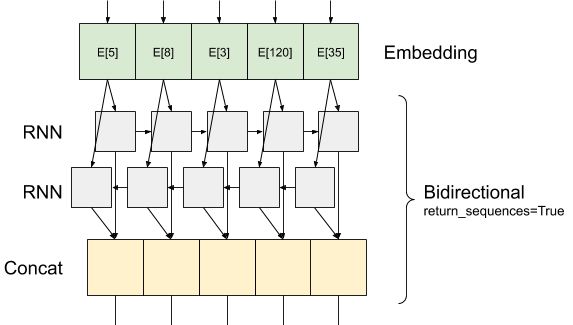

Hal yang menarik dari penggunaan RNN dengan return_sequences=True adalah outputnya masih memiliki 3 axis, sama seperti inputnya, sehingga bisa diteruskan ke layer RNN lain, seperti ini:

In [ ]:
# Membuat model Sequential
model = tf.keras.Sequential([
    encoder,  # Lapisan encoder untuk vektorisasi teks
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),  # Lapisan embedding
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),  # LSTM bidirectional
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),  # LSTM bidirectional
    tf.keras.layers.Dense(64, activation='relu'),  # Lapisan Dense dengan aktivasi ReLU
    tf.keras.layers.Dropout(0.5),  # Lapisan dropout
    tf.keras.layers.Dense(1)  # Lapisan Dense dengan satu keluaran
])


In [ ]:
# Mengkompilasi model dengan konfigurasi loss, optimizer, dan metrik
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),  # Menggunakan BinaryCrossentropy loss
    optimizer=tf.keras.optimizers.Adam(1e-4),  # Menggunakan optimizer Adam dengan learning rate 1e-4
    metrics=['accuracy']  # Menyertakan metrik akurasi
)


In [29]:
# Melatih model dengan dataset latihan selama 10 epoch
# dan melakukan validasi pada dataset uji
history = model.fit(
    train_dataset,  # Dataset latihan
    epochs=10,  # Jumlah epoch pelatihan
    validation_data=test_dataset,  # Dataset uji
    validation_steps=30  # Jumlah langkah validasi
)


Epoch 1/10
391/391 [==============================] - 721s 2s/step - loss: 0.6361 - accuracy: 0.5751 - val_loss: 0.4399 - val_accuracy: 0.8109
Epoch 2/10
391/391 [==============================] - 701s 2s/step - loss: 0.3894 - accuracy: 0.8306 - val_loss: 0.3515 - val_accuracy: 0.8490
Epoch 3/10
391/391 [==============================] - 701s 2s/step - loss: 0.3467 - accuracy: 0.8530 - val_loss: 0.3720 - val_accuracy: 0.8245
Epoch 4/10
391/391 [==============================] - 713s 2s/step - loss: 0.3282 - accuracy: 0.8635 - val_loss: 0.3302 - val_accuracy: 0.8583
Epoch 5/10
391/391 [==============================] - 694s 2s/step - loss: 0.3183 - accuracy: 0.8649 - val_loss: 0.3395 - val_accuracy: 0.8344
Epoch 6/10
391/391 [==============================] - 723s 2s/step - loss: 0.3142 - accuracy: 0.8674 - val_loss: 0.3184 - val_accuracy: 0.8615
Epoch 7/10
391/391 [==============================] - 713s 2s/step - loss: 0.3033 - accuracy: 0.8732 - val_loss: 0.3256 - val_accuracy: 0.8568

In [30]:
# Melakukan evaluasi model pada dataset uji
test_loss, test_acc = model.evaluate(test_dataset)

# Mencetak hasil evaluasi, yaitu nilai loss dan akurasi pada dataset uji
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)


391/391 [==============================] - 166s 425ms/step - loss: 0.3135 - accuracy: 0.8593
Test Loss: 0.31349557638168335
Test Accuracy: 0.859279990196228


In [31]:
# Contoh teks yang akan diprediksi tanpa padding
sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')

# Melakukan prediksi sentimen pada contoh teks tanpa padding menggunakan model yang telah dilatih
predictions = model.predict(np.array([sample_text]))

# Mencetak hasil prediksi
print(predictions)


1/1 [==============================] - 4s 4s/step
[[-1.7147856]]


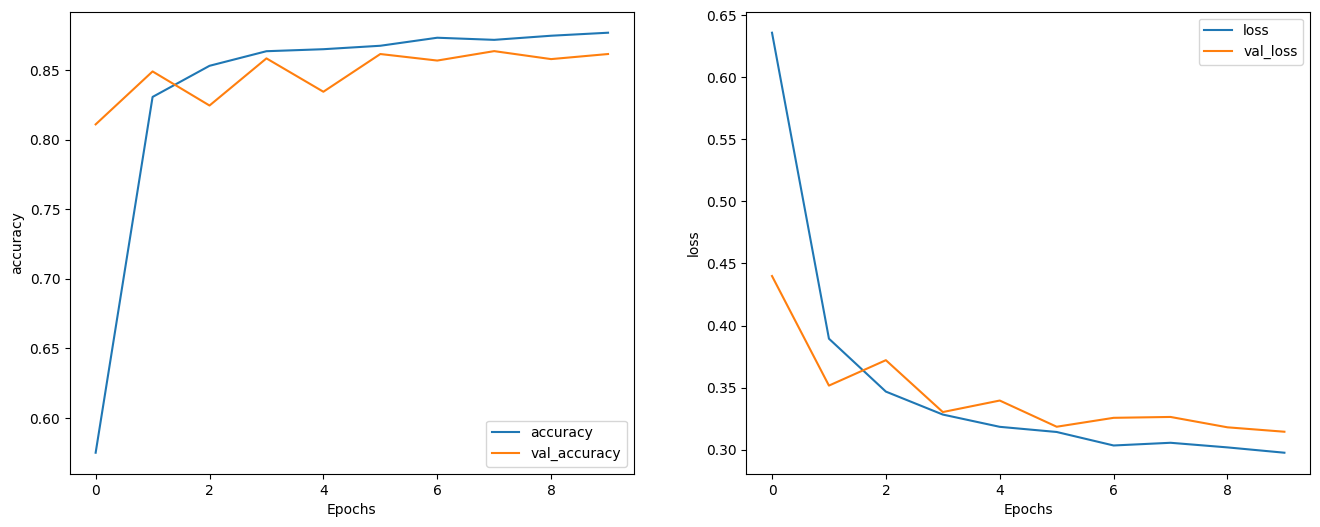

In [32]:
# Membuat gambar dengan ukuran 16x6 piksel
plt.figure(figsize=(16, 6))

# Mengatur subplot pertama untuk grafik akurasi
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')  # Memanggil fungsi plot_graphs untuk grafik akurasi

# Mengatur subplot kedua untuk grafik loss
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')  # Memanggil fungsi plot_graphs untuk grafik loss
